<h1> 2024 1학기 기계학습 심화 팀 프로젝트 </h1>
<h2>Pidray dataset을 이용한 Image Classification Using CNN</h2>

<h3>B911166 전민</h3>
<p>
<div>train data로는 29457장의 이미지를 사용하여 학습하였고 test data로는 9482장의 이미지를 사용하였다.</div>
<div>test data로는 각각 Hard, Easy, Hidden image set이 존재했고 그 중 금지 품목이 한 개만 포함된 Easy set을 사용하여 모델 테스트를 진행하였다.</div>
<div>https://github.com/bywang2018/security-dataset/blob/main/README.md</div>
</p>


In [1]:
!nvidia-smi

Thu May 16 12:44:25 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.44                 Driver Version: 552.44         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060      WDDM  |   00000000:06:00.0  On |                  N/A |
|  0%   40C    P0             N/A /  115W |     704MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

<h3>1)이미지 학습 진행(크롭 x)</h3>

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
import time
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [8]:
# load image
img =  cv2.imread('./pidray/train/images/xray_00000.png') # Reads an image into BGR Format

img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)   #load image with RGB format
img_size = img.shape
print(img_size)

(448, 620, 3)


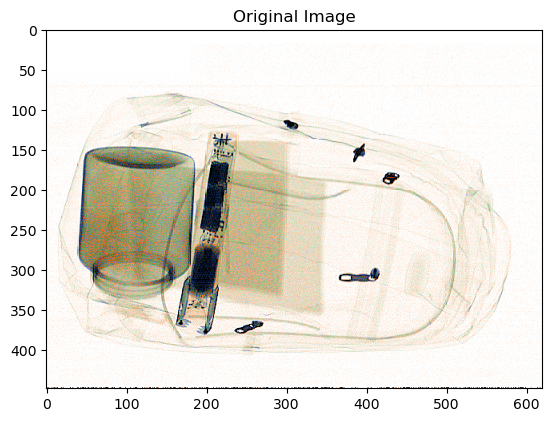

In [9]:
# Display original image
plt.imshow(img)
plt.title("Original Image")
plt.show()

In [10]:
all_pixels  = img.reshape((-1,3)).astype(float) # all_pixels : data
print(all_pixels.shape)

(277760, 3)


In [14]:


class CustomDataset(Dataset):
    def __init__(self, img_dir, annotation_dir, transform=None):
        self.img_dir = img_dir
        self.annotation_dir = annotation_dir
        self.transform = transform
        self.img_names = os.listdir(img_dir)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        annotation_path = os.path.join(self.annotation_dir, self.img_names[idx].replace('.png', '.txt'))

        image = Image.open(img_path).convert("RGB")
        
        with open(annotation_path, 'r') as f:
            bbox_data = f.readline().strip().split()
            label = int(bbox_data[0])
            bbox = torch.tensor([float(b) for b in bbox_data[1:]])
            
        if self.transform:
            image = self.transform(image)
        
        return image, label, bbox


In [16]:
root = './'

trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # 노말리이징: (원래 데이터 x - μ) / σ   μ=(0.5,0.5,0.5) σ = (0.5, 0.5, 0.5). 값이 세개인 이유는 RGB라서 채널이 세개이기 떄문
    transforms.Resize((240,300)) # 모든 이미지를 240 x 300의 사이즈로 리사이징
])

train_image_dir = root+'Pidray/train/images'
train_label_dir = root+'Pidray/train/labels'
test_image_dir = root+'Pidray/test/images'
test_label_dir = root+'Pidray/test/labels'

train_data = CustomDataset(train_image_dir, train_label_dir, transform=trans)
test_data = CustomDataset(test_image_dir, test_label_dir, transform=trans)

print('Training Data:', len(train_data), 'Test Data', len(test_data))


batch_size = 128
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=False)

Training Data: 29454 Test Data 9482


In [17]:
classes = ["Baton", "Pliers", "Hammer", "Powerbank", 
        "Scissors", "Wrench", "Gun", "Bullet", 
        "Sprayer", "Handcuffs", "Knife", "Lighter"]

In [18]:
import matplotlib.patches as patches

# 바운딩 박스를 그리는 함수
def draw_bbox(ax, bbox, label):
    # bbox = [x_center, y_center, width, height]
    # 이미지 크기에 따라 실제 바운딩 박스의 좌표로 변환
    x_center, y_center, width, height = bbox
    x1 = (x_center - width / 2) * 300   # 이미지 너비에 맞춰 조정
    y1 = (y_center - height / 2) * 240  # 이미지 높이에 맞춰 조정
    
    # 바운딩 박스 그리기
    rect = patches.Rectangle((x1, y1), width * 300, height * 240, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    # 라벨 표시
    ax.text(x1, y1, label, color='white', backgroundcolor='red')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

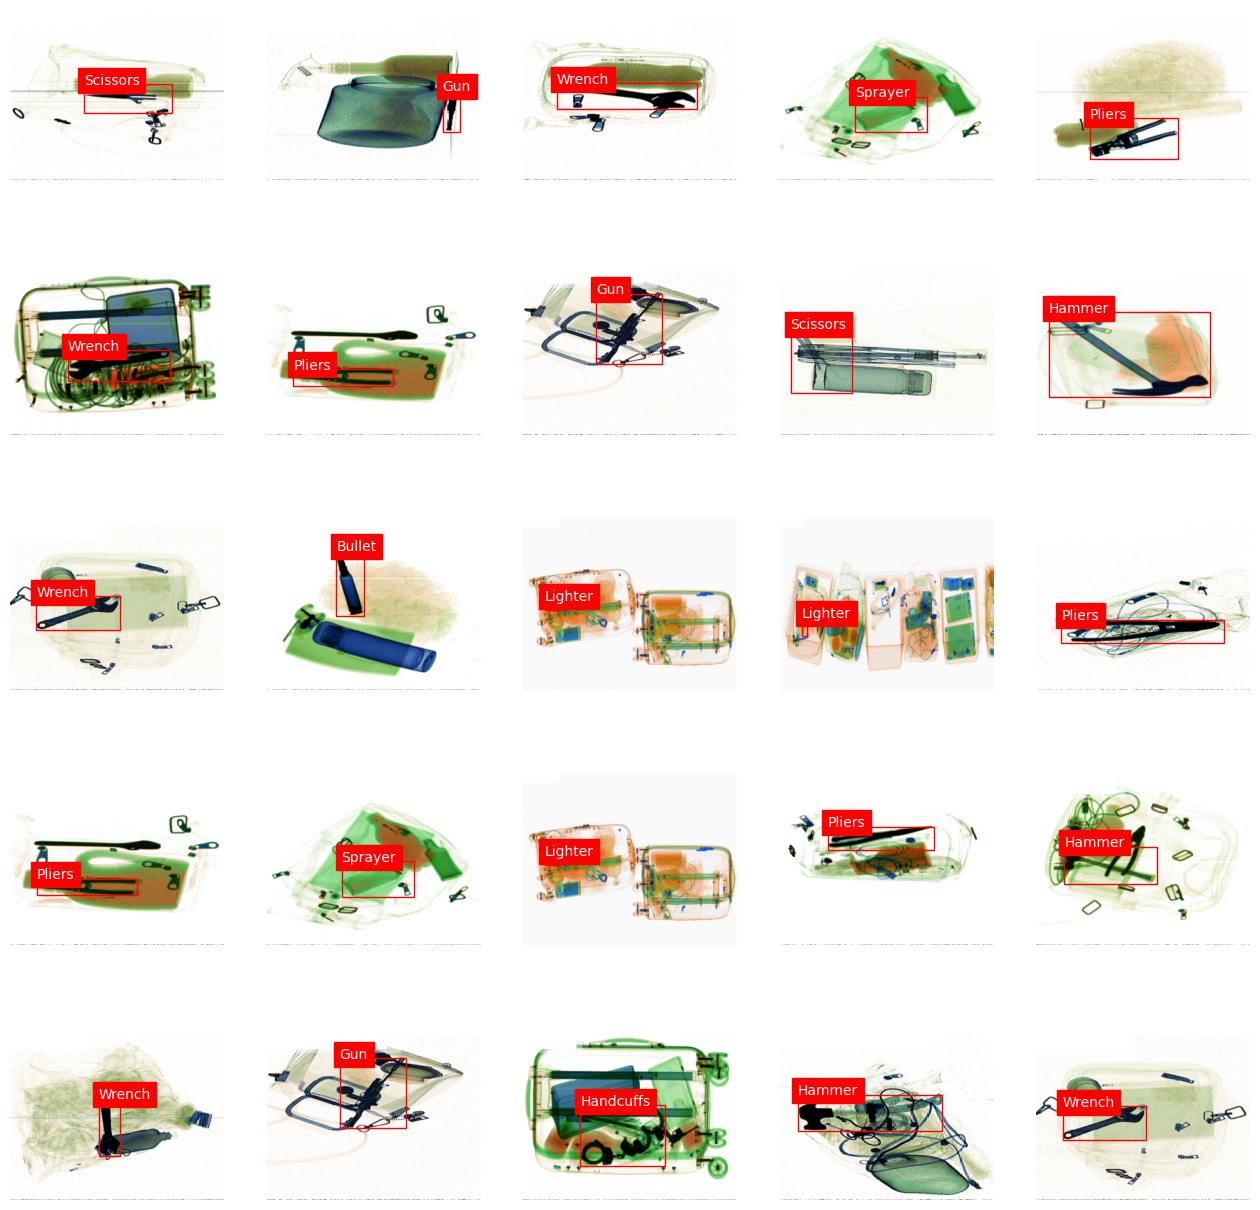

In [19]:
# 데이터 로더에서 첫 번째 배치만 가져오기
images, labels, bboxes = next(iter(train_loader))

# batch size: 64, kernel: 3(RGB), image size: 480 x 600
sample_index = np.random.choice(batch_size, size=25)     # 25개의 랜덤 샘플 인덱스 선택
num_samples = sample_index.size

random_samples = images[sample_index].cpu().numpy()

plt.figure(figsize=(16, 16))

# 테스트 샘플 표시
for k in range(num_samples):
    ax = plt.subplot(5, 5, k + 1)
    img = random_samples[k].reshape(3,240, 300).transpose(1,2,0)/2 + 0.5
    plt.imshow(img)
    label = classes[labels[sample_index[k]].item()]
    bbox = bboxes[sample_index[k]] # 해당 샘플의 바운딩 박스 정보
    draw_bbox(ax, bbox, label) # 바운딩 박스 그리기
    plt.axis('off')

plt.show() 

In [20]:
class MyConvNet(nn.Module):
    def __init__(self):
        super(MyConvNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 5),   # RGB 이미지를 위해 입력 채널을 3으로 설정
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(64 * 57 * 72, 512),  # 이미지 크기와 출력 채널을 반영하여 입력 크기 조정
            nn.ReLU(),  # 학습을 개선하기 위해 활성화 함수 추가
            nn.Linear(512, 12)  # 클래스가 총 12개이므로 마지막 채널 수를 12로 조정
        )

    def forward(self, x):
        logits = self.conv_layers(x)
        return(logits)
    
model = MyConvNet().to(device)
print(model)

MyConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=262656, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=12, bias=True)
  )
)


In [21]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)

criterion = nn.CrossEntropyLoss()

In [122]:
# training and test

# epoch: 10
# data dimension: batch_size x Channels x Height x Width (NCHW)
for epoch in range(10):
    # training phase
    # model.train()  # drop out layer가 있다면 drop out을 활성화. 지금은 없어서 상관 없음
    current_loss= 0.0
    for batch_num, (x, target, bbox) in enumerate(train_loader):
        x, target = x.to(device), target.to(device)

        # forward propagation
        out = model(x)
        loss = criterion(out,target)

        # backward propagation
        optimizer.zero_grad()   # 미분값 리셋
        loss.backward()
        optimizer.step()
        current_loss += loss

        # display the training loss in every 50 batches
        if (batch_num+1)%50 == 0 or (batch_num+1)%50 == len(train_loader):
            print('epoch: %d, batch_num: %d, current_loss: %.3f' %(epoch, batch_num+1, current_loss/100))
            current_loss = 0.0


    # test phase
    with torch.no_grad():
        # model.eval()        # test시에는 drop out을 적용하면 안됨. 만일 drop out이 켜져있다면 eval()로 모든 레이어를 활성화할 수 있다.
        total_samples = 0.0
        correct_samples = 0.0
        for (x, target, bbox) in test_loader:
            x, target = x.to(device), target.to(device)
            out = model(x)
            pred = torch.argmax(out,1)
            correct_samples += (pred == target).sum()
        print('Accuracy: %.3f' %(100*float(correct_samples) / float(len(test_data))))

epoch: 0, batch_num: 50, current_loss: 1.264
epoch: 0, batch_num: 100, current_loss: 1.155
epoch: 0, batch_num: 150, current_loss: 1.121
epoch: 0, batch_num: 200, current_loss: 1.093
Accuracy: 26.049
epoch: 1, batch_num: 50, current_loss: 1.010
epoch: 1, batch_num: 100, current_loss: 0.992
epoch: 1, batch_num: 150, current_loss: 0.964
epoch: 1, batch_num: 200, current_loss: 0.954
Accuracy: 30.352
epoch: 2, batch_num: 50, current_loss: 0.879
epoch: 2, batch_num: 100, current_loss: 0.862
epoch: 2, batch_num: 150, current_loss: 0.838
epoch: 2, batch_num: 200, current_loss: 0.843
Accuracy: 34.233
epoch: 3, batch_num: 50, current_loss: 0.725
epoch: 3, batch_num: 100, current_loss: 0.730
epoch: 3, batch_num: 150, current_loss: 0.729
epoch: 3, batch_num: 200, current_loss: 0.725
Accuracy: 35.246
epoch: 4, batch_num: 50, current_loss: 0.598
epoch: 4, batch_num: 100, current_loss: 0.609
epoch: 4, batch_num: 150, current_loss: 0.588
epoch: 4, batch_num: 200, current_loss: 0.589
Accuracy: 32.757


In [123]:
torch.save(model, 'model1.pth') # 모델 저장

<h3>2)모델 불러와서 크롭한 이미지로 재학습 진행</h3>

In [7]:
import os
import time
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

In [ ]:
# 네트워크 구조 재정의
class MyConvNet(nn.Module):
    def __init__(self):
        super(MyConvNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 5),   # RGB 이미지를 위해 입력 채널을 3으로 설정
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(64 * 57 * 72, 512),  # 이미지 크기와 출력 채널을 반영하여 입력 크기 조정
            nn.ReLU(),  # 학습을 개선하기 위해 활성화 함수 추가
            nn.Linear(512, 12)  # 클래스가 총 12개이므로 마지막 채널 수를 12로 조정
        )

    def forward(self, x):
        logits = self.conv_layers(x)
        return(logits)

In [23]:
model = torch.load('model1.pth') #모델 불러오기

MyConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=262656, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=12, bias=True)
  )
)

In [24]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, annotation_dir, transform=None):
        self.img_dir = img_dir
        self.annotation_dir = annotation_dir
        self.transform = transform
        self.img_names = os.listdir(img_dir)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        annotation_path = os.path.join(self.annotation_dir, self.img_names[idx].replace('.png', '.txt'))

        image = Image.open(img_path).convert("RGB")
        
        with open(annotation_path, 'r') as f:
            bbox_data = f.readline().strip().split()
            label = int(bbox_data[0])
            bbox = [float(b) for b in bbox_data[1:]] # x_center, y_center, width, height

        # 이미지 크기에 맞춰 실제 바운딩 박스의 좌표로 변환
        x_center, y_center, width, height = bbox
        x1 = int((x_center - width / 2) * image.width)
        y1 = int((y_center - height / 2) * image.height)
        x2 = int((x_center + width / 2) * image.width)
        y2 = int((y_center + height / 2) * image.height)

        # 이미지를 바운딩 박스에 맞춰서 crop
        image = image.crop((x1, y1, x2, y2))
        
        if self.transform:
            image = self.transform(image)
        
        return image, label, torch.tensor(bbox)


In [25]:
root = './'

trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # 노말리이징: (원래 데이터 x - μ) / σ   μ=(0.5,0.5,0.5) σ = (0.5, 0.5, 0.5). 값이 세개인 이유는 RGB라서 채널이 세개이기 떄문
    transforms.Resize((240,300)) # 모든 이미지를 240 x 300의 사이즈로 리사이징
])

train_image_dir = root+'Pidray/train/images'
train_label_dir = root+'Pidray/train/labels'
test_image_dir = root+'Pidray/test/images'
test_label_dir = root+'Pidray/test/labels'

train_data = CustomDataset(train_image_dir, train_label_dir, transform=trans)
test_data = CustomDataset(test_image_dir, test_label_dir, transform=trans)

print('Training Data:', len(train_data), 'Test Data', len(test_data))


batch_size = 128
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=False)

Training Data: 29454 Test Data 9482


In [26]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)

criterion = nn.CrossEntropyLoss()

In [ ]:
# for param in model.parameters():
#     param.requires_grad = False

# # 마지막 레이어의 파라미터를 학습 가능하게 설정
# model.fc.requires_grad = True

In [29]:
# training and test

# epoch: 10
# data dimension: batch_size x Channels x Height x Width (NCHW)
for epoch in range(10):
    epoch_start_time = time.time()  # 에폭 시작 시간 기록
    # training phase
    # model.train()  # drop out layer가 있다면 drop out을 활성화. 지금은 없어서 상관 없음
    current_loss= 0.0
    for batch_num, (x, target, bbox) in enumerate(train_loader):
        start_time = time.time()  # 배치 처리 시작 시간 기록
        x, target = x.to(device), target.to(device)

        # forward propagation
        out = model(x)
        loss = criterion(out,target)

        # backward propagation
        optimizer.zero_grad()   # 미분값 리셋
        loss.backward()
        optimizer.step()
        current_loss += loss

        # display the training loss in every 50 batches
        if (batch_num+1)%50 == 0 or (batch_num+1)%50 == len(train_loader):
            batch_time = time.time() - start_time  # 배치 처리 시간 계산
            total_time = time.time() - epoch_start_time  # 총 경과 시간 계산
            print('epoch: %d, batch_num: %d, current_loss: %.3f, batch_time: %.3f, total_time: %.3f' % (epoch, batch_num + 1, current_loss/50, batch_time, total_time))
            current_loss = 0.0


    # test phase
    with torch.no_grad():
        # model.eval()        # test시에는 drop out을 적용하면 안됨. 만일 drop out이 켜져있다면 eval()로 모든 레이어를 활성화할 수 있다.
        total_samples = 0.0
        correct_samples = 0.0
        for (x, target, bbox) in test_loader:
            x, target = x.to(device), target.to(device)
            out = model(x)
            pred = torch.argmax(out,1)
            correct_samples += (pred == target).sum()
        print('Accuracy: %.3f' %(100*float(correct_samples) / float(len(test_data))))

epoch: 0, batch_num: 50, current_loss: 2.305, batch_time: 0.037, total_time: 300.014
epoch: 0, batch_num: 100, current_loss: 1.408, batch_time: 0.016, total_time: 532.027
epoch: 0, batch_num: 150, current_loss: 1.127, batch_time: 0.016, total_time: 870.677
epoch: 0, batch_num: 200, current_loss: 0.963, batch_time: 0.018, total_time: 1077.615
Accuracy: 61.306
epoch: 1, batch_num: 50, current_loss: 0.690, batch_time: 0.016, total_time: 74.803
epoch: 1, batch_num: 100, current_loss: 0.642, batch_time: 0.016, total_time: 149.503
epoch: 1, batch_num: 150, current_loss: 0.591, batch_time: 0.017, total_time: 222.196
epoch: 1, batch_num: 200, current_loss: 0.539, batch_time: 0.016, total_time: 296.586
Accuracy: 67.285
epoch: 2, batch_num: 50, current_loss: 0.356, batch_time: 0.018, total_time: 34.236
epoch: 2, batch_num: 100, current_loss: 0.353, batch_time: 0.017, total_time: 67.230
epoch: 2, batch_num: 150, current_loss: 0.342, batch_time: 0.015, total_time: 100.901
epoch: 2, batch_num: 200,

In [30]:
torch.save(model, 'model2.pth') # 모델 저장

<h3>3) 기존 모델 불러와서 정확도 테스트</h3>

In [12]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import torch.nn as nn
from PIL import Image
import os
import torchvision
import torchvision.transforms as transforms

In [13]:
# 네트워크 구조 재정의
class MyConvNet(nn.Module):
    def __init__(self):
        super(MyConvNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 5),   # RGB 이미지를 위해 입력 채널을 3으로 설정
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(64 * 57 * 72, 512),  # 이미지 크기와 출력 채널을 반영하여 입력 크기 조정
            nn.ReLU(),  # 학습을 개선하기 위해 활성화 함수 추가
            nn.Linear(512, 12)  # 클래스가 총 12개이므로 마지막 채널 수를 12로 조정
        )

    def forward(self, x):
        logits = self.conv_layers(x)
        return(logits)

In [14]:
# 모델을 불러오기
model = torch.load('model1.pth')
model.eval()  # 모델을 평가 모드로 설정

MyConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=262656, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=12, bias=True)
  )
)

In [16]:
# device 설정 (GPU가 사용 가능하면 GPU 사용, 아니면 CPU 사용)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

model.to(device)

Using cuda device


MyConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=262656, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=12, bias=True)
  )
)

In [15]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, annotation_dir, transform=None):
        self.img_dir = img_dir
        self.annotation_dir = annotation_dir
        self.transform = transform
        self.img_names = os.listdir(img_dir)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        annotation_path = os.path.join(self.annotation_dir, self.img_names[idx].replace('.png', '.txt'))

        image = Image.open(img_path).convert("RGB")
        
        with open(annotation_path, 'r') as f:
            bbox_data = f.readline().strip().split()
            label = int(bbox_data[0])
            bbox = torch.tensor([float(b) for b in bbox_data[1:]])
            
        if self.transform:
            image = self.transform(image)
        
        return image, label, bbox

In [ ]:
root = './'

trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # 노말리이징: (원래 데이터 x - μ) / σ   μ=(0.5,0.5,0.5) σ = (0.5, 0.5, 0.5). 값이 세개인 이유는 RGB라서 채널이 세개이기 떄문
    transforms.Resize((240,300)) # 모든 이미지를 240 x 300의 사이즈로 리사이징
])

test_image_dir = root+'Pidray/test/images'
test_label_dir = root+'Pidray/test/labels'

test_data = CustomDataset(test_image_dir, test_label_dir, transform=trans)

batch_size = 128

# 테스트 데이터 로더 설정 (위에서 정의한 test_loader 사용)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [17]:
correct_samples = 0
total_samples = 0

with torch.no_grad():  # 기울기 계산을 하지 않음
    for x, target, _ in test_loader:  # bbox는 평가에 사용하지 않으므로 무시
        x, target = x.to(device), target.to(device)
        output = model(x)
        _, predicted = torch.max(output.data, 1)
        total_samples += target.size(0)
        correct_samples += (predicted == target).sum().item()

accuracy = 100.0 * correct_samples / total_samples
print(f'Accuracy of the network on the test images: {accuracy:.2f}%')

Accuracy of the network on the test images: 37.44%


<h3>4) 재학습 모델 불러와서 정확도 테스트</h3>

In [25]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import torch.nn as nn
from PIL import Image
import os
import torchvision
import torchvision.transforms as transforms

In [26]:
# 네트워크 구조 재정의
class MyConvNet(nn.Module):
    def __init__(self):
        super(MyConvNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 5),   # RGB 이미지를 위해 입력 채널을 3으로 설정
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(64 * 57 * 72, 512),  # 이미지 크기와 출력 채널을 반영하여 입력 크기 조정
            nn.ReLU(),  # 학습을 개선하기 위해 활성화 함수 추가
            nn.Linear(512, 12)  # 클래스가 총 12개이므로 마지막 채널 수를 12로 조정
        )

    def forward(self, x):
        logits = self.conv_layers(x)
        return(logits)

In [27]:
# 모델을 불러오기
model = torch.load('model2.pth')
model.eval()  # 모델을 평가 모드로 설정

MyConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=262656, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=12, bias=True)
  )
)

In [28]:
# device 설정 (GPU가 사용 가능하면 GPU 사용, 아니면 CPU 사용)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

model.to(device)

Using cuda device


MyConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=262656, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=12, bias=True)
  )
)

In [29]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, annotation_dir, transform=None):
        self.img_dir = img_dir
        self.annotation_dir = annotation_dir
        self.transform = transform
        self.img_names = os.listdir(img_dir)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        annotation_path = os.path.join(self.annotation_dir, self.img_names[idx].replace('.png', '.txt'))

        image = Image.open(img_path).convert("RGB")
        
        with open(annotation_path, 'r') as f:
            bbox_data = f.readline().strip().split()
            label = int(bbox_data[0])
            bbox = torch.tensor([float(b) for b in bbox_data[1:]])
            
        if self.transform:
            image = self.transform(image)
        
        return image, label, bbox

In [30]:
root = './'

trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # 노말리이징: (원래 데이터 x - μ) / σ   μ=(0.5,0.5,0.5) σ = (0.5, 0.5, 0.5). 값이 세개인 이유는 RGB라서 채널이 세개이기 떄문
    transforms.Resize((240,300)) # 모든 이미지를 240 x 300의 사이즈로 리사이징
])

test_image_dir = root+'Pidray/test/images'
test_label_dir = root+'Pidray/test/labels'

test_data = CustomDataset(test_image_dir, test_label_dir, transform=trans)

batch_size = 128

# 테스트 데이터 로더 설정 (위에서 정의한 test_loader 사용)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [31]:
correct_samples = 0
total_samples = 0

with torch.no_grad():  # 기울기 계산을 하지 않음
    for x, target, _ in test_loader:  # bbox는 평가에 사용하지 않으므로 무시
        x, target = x.to(device), target.to(device)
        output = model(x)
        _, predicted = torch.max(output.data, 1)
        total_samples += target.size(0)
        correct_samples += (predicted == target).sum().item()

accuracy = 100.0 * correct_samples / total_samples
print(f'Accuracy of the network on the test images: {accuracy:.2f}%')


Accuracy of the network on the test images: 14.34%
